In [ ]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label='', _backward=None):
        self.data = data
        # at init, grad is 0 because we don't know the gradient yet during forward pass
        self.grad = 0.0
        # set of previous nodes - '_children' because viewed during backward pass (parents if viewed from forward pass)
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = _backward
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+', f'{self.label}+{other.label}')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*', f'{self.label}*{other.label}')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):
        out = Value(self.data ** other.data, (self, other), '**', f'{self.label}**{other.label}')

        def _backward():
            self.grad += other.data * (self.data**(other.data-1)) * out.grad
            other.grad += (self.data**other.data)*math.log(self.data)*out.grad

        out._backward = _backward

        return out
    
    def __neg__(self):
        out = Value(-self.data, (self,), '-', f'-{self.label}')

        def _backward():
            self.grad += -1 * out.grad

        out._backward = _backward

        return out
    
    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), '-', f'{self.label}-{other.label}')

        def _backward():
            self.grad += out.grad
            other.grad += -1 * out.grad

        out._backward = _backward

        return out

    def __rsub__(self, other):
        out = Value(other.data - self.data, (self, other), '-', f'{other.label}-{self.label}')

        def _backward():
            self.grad += -1 * out.grad
            other.grad += out.grad

        out._backward = _backward

        return out

In [48]:
x = Value(10.0, label='x')
y = Value(20.0, label='y')
z = Value(2.0, label='z')

a = x + y*z

In [49]:
a._prev

{Value(data=10.0, label=x), Value(data=40.0, label=y*z)}

In [50]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

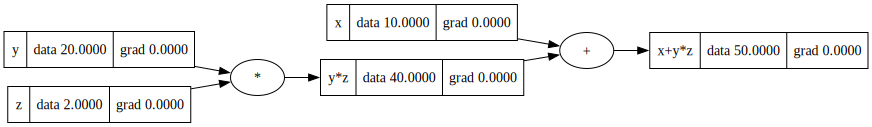

In [51]:
draw_dot(a)